In [1]:
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from matplotlib import pyplot as plt
from anomalib.models.segad.crf import dense_crf

import torch

device = torch.device('cuda:1')

In [12]:
model = None
batch = None
torch.cuda.empty_cache()

config = get_configurable_parameters(model_name='fastflow', 
                                     config_path='./src/anomalib/models/fastflow/loco_config.yaml')
datamodule = get_datamodule(config)
model = get_model(config).to(device)
model.load_state_dict(
    torch.load('./results/fastflow/mvtec_loco/breakfast_box/run/weights/lightning/model-v1.ckpt')['state_dict'], 
    strict=False
)
model.eval()
# print(1)

/home/lucien/repos/anomalib/src/anomalib/config/config.py:278: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(
/home/lucien/anaconda3/envs/cuda1103_torch110/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


FastflowLightning(
  (image_threshold): AnomalyScoreThreshold()
  (pixel_threshold): AnomalyScoreThreshold()
  (model): FastflowModel(
    (feature_extractor): FeatureListNet(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (act1): ReLU(inplace=True)
          (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (drop_block): Identity()
          (a

In [3]:
datamodule.setup()
train_dataloader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()
it = iter(val_dataloader)

['logical_anomalies']


In [7]:
batch = it.__next__()
print(batch['image_path'])

['datasets/MVTec_LOCO/breakfast_box/test/good/096.png', 'datasets/MVTec_LOCO/breakfast_box/test/good/097.png', 'datasets/MVTec_LOCO/breakfast_box/test/good/098.png', 'datasets/MVTec_LOCO/breakfast_box/test/good/099.png', 'datasets/MVTec_LOCO/breakfast_box/test/good/100.png', 'datasets/MVTec_LOCO/breakfast_box/test/good/101.png', 'datasets/MVTec_LOCO/breakfast_box/test/logical_anomalies/000.png', 'datasets/MVTec_LOCO/breakfast_box/test/logical_anomalies/001.png', 'datasets/MVTec_LOCO/breakfast_box/test/logical_anomalies/002.png', 'datasets/MVTec_LOCO/breakfast_box/test/logical_anomalies/003.png', 'datasets/MVTec_LOCO/breakfast_box/test/logical_anomalies/004.png', 'datasets/MVTec_LOCO/breakfast_box/test/logical_anomalies/005.png', 'datasets/MVTec_LOCO/breakfast_box/test/logical_anomalies/006.png', 'datasets/MVTec_LOCO/breakfast_box/test/logical_anomalies/007.png', 'datasets/MVTec_LOCO/breakfast_box/test/logical_anomalies/008.png', 'datasets/MVTec_LOCO/breakfast_box/test/logical_anomalies

In [8]:
with torch.no_grad():
    ret = model.model(batch['image'].to(device))

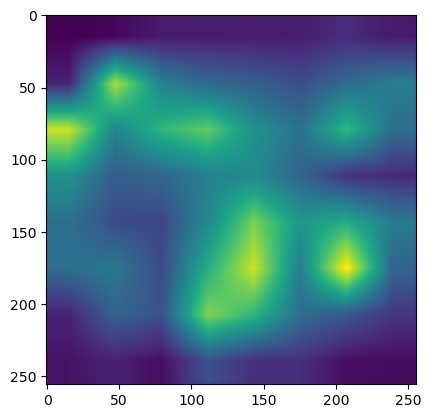

In [10]:
plt.imshow(ret[0][0].squeeze().cpu())

In [11]:
ret[0].mean([2, 3])

tensor([[-7.3373e-01],
        [-7.3596e-01],
        [-7.3426e-01],
        [-7.2406e-01],
        [-7.5367e-01],
        [-7.3293e-01],
        [-2.5903e-16],
        [-1.4448e-06],
        [-4.9166e-25],
        [-7.4654e-01],
        [-7.2628e-01],
        [-7.1624e-01],
        [-7.5191e-01],
        [-7.3802e-01],
        [-7.1111e-01],
        [-7.2831e-01],
        [-7.1757e-01],
        [-7.2716e-01],
        [-7.0924e-01],
        [-7.2583e-01],
        [-7.0556e-01],
        [-7.1737e-01],
        [-7.2806e-01],
        [-6.9364e-01],
        [-7.0736e-01],
        [-7.5620e-01],
        [-7.2899e-01],
        [-7.2610e-01],
        [-7.4033e-01],
        [-7.2896e-01],
        [-7.0246e-01],
        [-3.4247e-01]], device='cuda:1')

In [6]:
with torch.no_grad():
    seg_batch = model.get_seg_batch(batch).to(device)
    ae_out = model.model.ae(batch['image'].to(device))
    st_out = model.model.student(batch['image'].to(device))
    score = torch.mean((ae_out - st_out) ** 2, 1)
    # out = stout.softmax(dim=1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


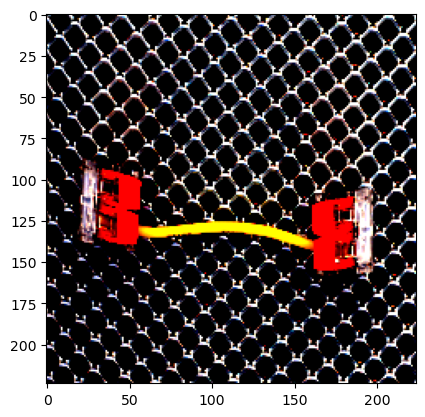

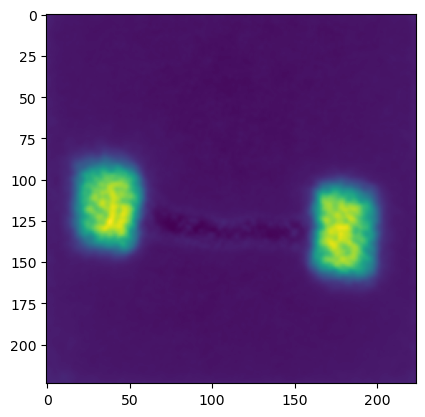

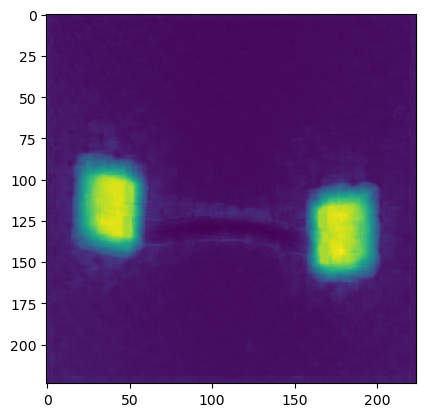

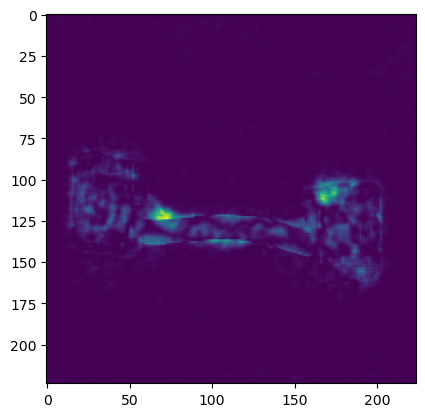

In [7]:
idx = 14

plt.imshow(batch['image'][idx].permute(1, 2, 0))
plt.show()

# print(ae_out[idx][1])
# print(seg_batch[idx][1])
plt.imshow(ae_out[idx][4].cpu())
plt.show()
plt.imshow(st_out[idx][4].cpu())
plt.show()
plt.imshow(score[idx].cpu())

In [22]:
import timm
import torchvision.transforms.functional as F

feature_extractor = timm.create_model(
      'wide_resnet50_2',
      pretrained=True,
      features_only=True,
      exportable=True,
).to(device)

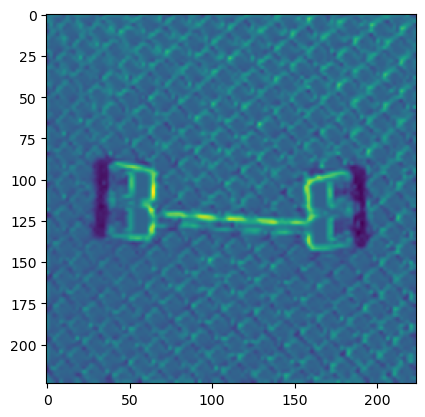

In [34]:
with torch.no_grad():
    feat = feature_extractor(batch['image'].to(device))
plt.imshow(F.resize(feat[0][4:5], 224)[0].mean(0).cpu())

In [68]:
with torch.no_grad():
    teacher_output = model.model.teacher(batch['image'].to(device))
    student_output = model.model.student(batch['image'].to(device))
    ae_output = model.model.ae(batch['image'].to(device))
    distance_st = torch.pow(teacher_output - student_output[:, :384, :, :], 2).mean(dim=1, keepdim=True)
    distance_ae = torch.pow(ae_output - student_output[:, 384:, :, :], 2).mean(dim=1, keepdim=True)
    distance_att = torch.pow(ae_output - teacher_output, 2).mean(dim=1, keepdim=True)

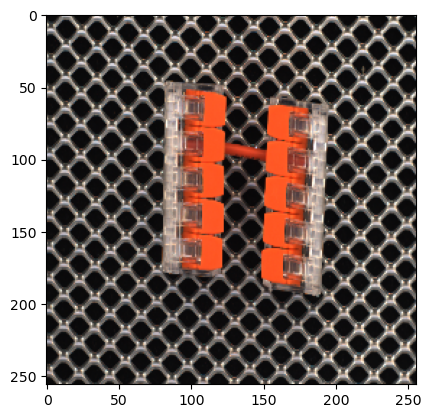

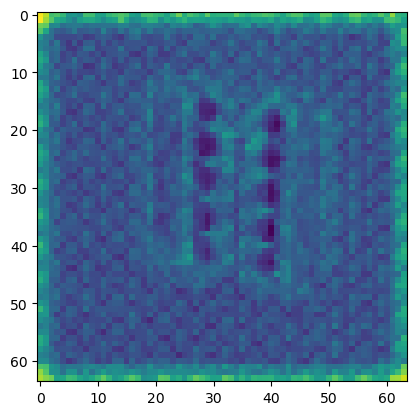

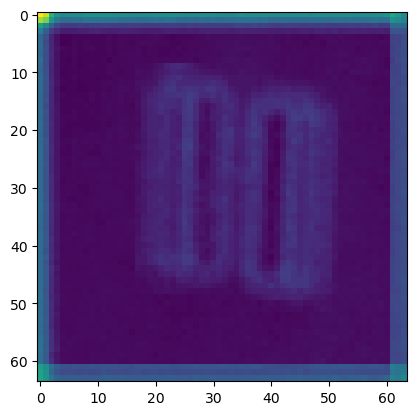

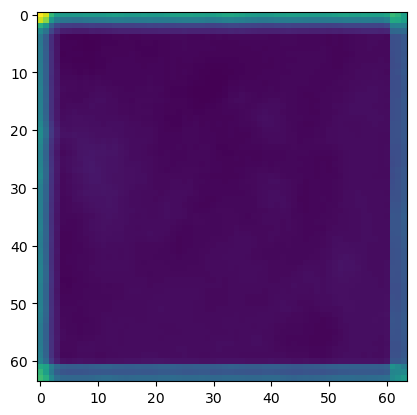

In [73]:
idx = 3
plt.imshow(batch['image'][idx].permute(1, 2, 0))
plt.show()
plt.imshow(teacher_output[idx].mean(0).cpu())
plt.show()
plt.imshow(student_output[idx, 384:].mean(0).cpu())
plt.show()
plt.imshow(ae_output[idx].mean(0).cpu())

In [12]:
embedding = teacher_output[0]
embedding = embedding / embedding.norm(dim=1, keepdim=True)
corr = torch.einsum('cwh,cij->whij', embedding, embedding)

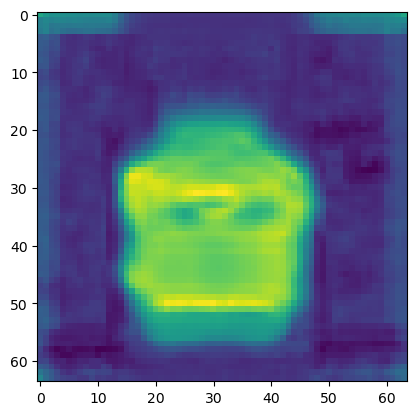

In [16]:
plt.imshow(corr[50, 30].cpu())

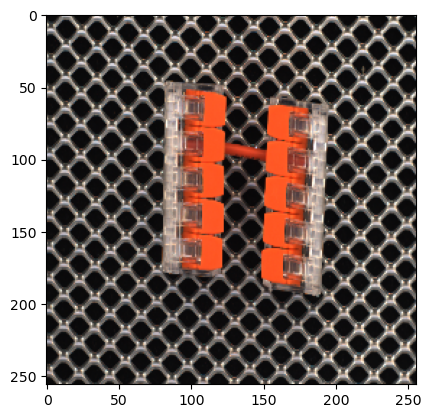

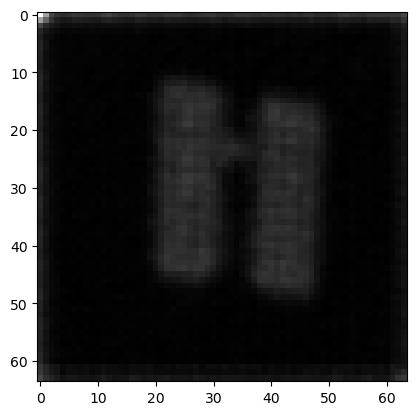

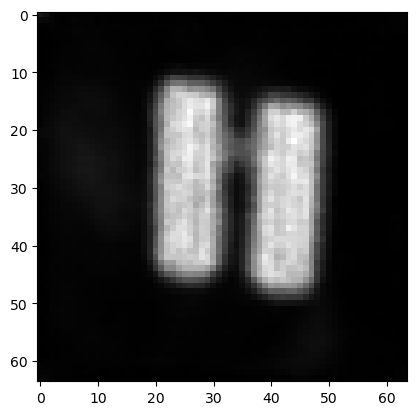

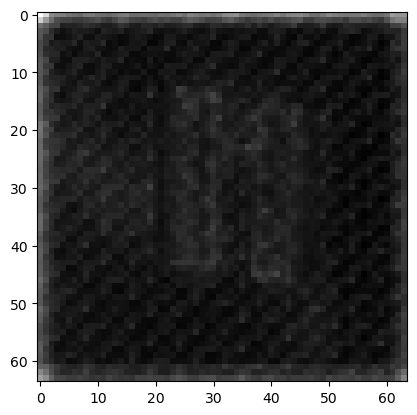

In [75]:
idx = 3
plt.imshow(batch['image'][idx].permute(1, 2, 0))
plt.show()
plt.imshow(distance_st[idx, ...][0].cpu().detach().numpy(), cmap='gray')
plt.show()
plt.imshow(distance_ae[idx, ...][0].cpu().detach().numpy(), cmap='gray')
plt.show()
plt.imshow(distance_att[idx, ...][0].cpu().detach(), cmap='gray')

In [551]:
from anomalib.config import get_configurable_parameters
from anomalib.data import get_datamodule
from anomalib.models import get_model
from matplotlib import pyplot as plt

import torch

device = torch.device('cuda:1')

model = None
batch = None
torch.cuda.empty_cache()

config = get_configurable_parameters(model_name='patchcore', 
                                     config_path='./src/anomalib/models/patchcore/loco_config.yaml')
datamodule = get_datamodule(config)
model = get_model(config).to(device)
model.load_state_dict(torch.load('./results/patchcore/mvtec_loco/juice_bottle/run/weights/lightning/model-v4.ckpt',
                                 map_location=model.device)['state_dict'], strict=False)

datamodule.setup()
train_dataloader = datamodule.train_dataloader()
val_dataloader = datamodule.val_dataloader()
it = iter(val_dataloader)

/home/lucien/repos/anomalib/src/anomalib/config/config.py:241: UserWarning: The seed value is now fixed to 0. Up to v0.3.7, the seed was not fixed when the seed value was set to 0. If you want to use the random seed, please select `None` for the seed value (`null` in the YAML file) or remove the `seed` key from the YAML file.
  warn(
/home/lucien/repos/anomalib/src/anomalib/config/config.py:278: UserWarning: config.project.unique_dir is set to False. This does not ensure that your results will be written in an empty directory and you may overwrite files.
  warn(
/home/lucien/anaconda3/envs/cuda1103_torch110/lib/python3.8/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `PrecisionRecallCurve` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


['logical_anomalies']


In [552]:
batch = it.__next__()
img = batch['image']

In [553]:
img = img.to(device)
with torch.no_grad():
    features = model.model.feature_extractor.get_intermediate_layers(
        img,
        n=1,
        reshape=True,
        norm=True
    )[0]
    embedding = features
    
# embedding = features
embedding = embedding / torch.norm(embedding, dim=1, keepdim=True)
batch_size, _, width, height = embedding.shape
corr = torch.einsum('ncij,nchw->nijhw', embedding, embedding)
corr = corr.reshape((corr.shape[0], -1, width, height))
embedding = corr
embedding = model.model.reshape_embedding(embedding)
# apply nearest neighbor search
patch_scores, locations = model.model.nearest_neighbors(embedding=embedding, n_neighbors=1)
# N, n_neighbors = locations.shape
nearest_embedding = model.model.memory_bank[locations]
# nearest_embedding = nearest_embedding.reshape((N, n_neighbors, -1))

distances = (
    (embedding - nearest_embedding) ** 2
)
distances = distances.reshape([batch_size, width * height, -1])
# distances = distances / (distances.norm(dim=-1, keepdim=True) + 1e-10)
# distances = distances.mean(dim=1)
distances = distances.quantile(0.1, dim=1)
patch_scores = distances

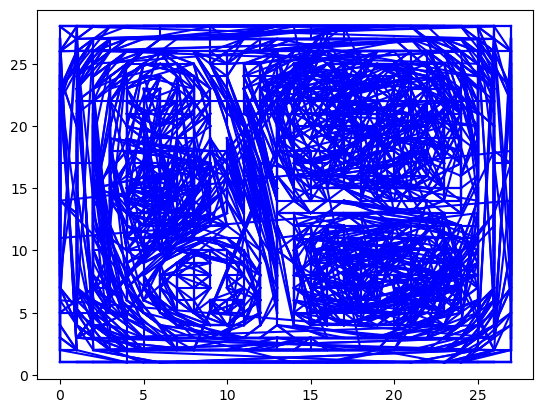

In [554]:
import numpy as np

def decode(idx):
    x1, tmp = torch.div(idx, 28 * 28 * 28, rounding_mode='floor'), idx % (28 * 28 * 28)
    y1, tmp = torch.div(idx, 28 * 28, rounding_mode='floor'), tmp % (28 * 28)
    x2, y2 = torch.div(idx, 28, rounding_mode='floor'), tmp % 28
    return x1, y1, x2, y2

corr_ = corr.reshape([32, 28, 28, 28, 28])[0]
corr_[corr_ == 1.0] = 0
corr_flatten = corr_.view(28 * 28, 28 * 28)
vals, indices = corr_flatten.topk(6, dim=1)
x, y = torch.div(indices, 28, rounding_mode='floor'), indices % 28
p1 = torch.stack((x, y), dim=-1).cpu()
p2 = torch.arange(784).unsqueeze(1).repeat(1, 6)
x, y = torch.div(p2, 28, rounding_mode='floor'), p2 % 28
p2 = torch.stack((x, y), dim=-1)
pair = torch.cat((p2, p1), dim=-1)

pair = pair.view(28 * 28 * 6, -1)
for line in pair:
    plt.plot([line[1], line[3]], [28 - line[0], 28 - line[2]], color='blue')
plt.show()

In [398]:
tmp = (
    (embedding - nearest_embedding) ** 2
)
tmp = tmp.reshape(batch_size, width, height, width, height)
ano = tmp[idx][..., 9, 25]
torch.where(ano > 0.5)

(tensor([], device='cuda:1', dtype=torch.int64),
 tensor([], device='cuda:1', dtype=torch.int64))

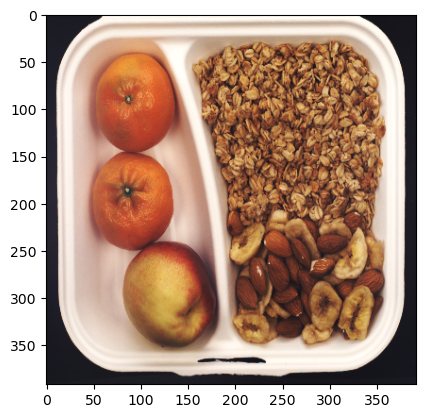

tensor(0.0188, device='cuda:1')


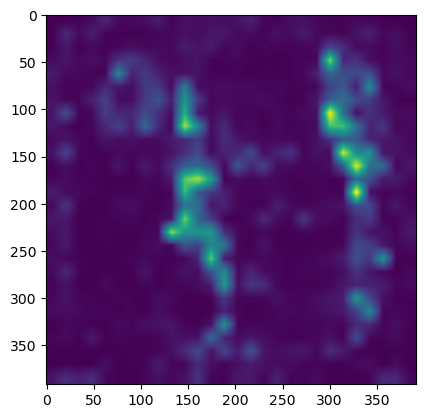

In [555]:
idx = 0
plt.imshow(img[idx].permute(1, 2, 0).cpu())
plt.show()
plt.imshow(F.resize(patch_scores[idx].reshape((1, 28, 28)), 392)[0].cpu())
print(patch_scores[idx].max())

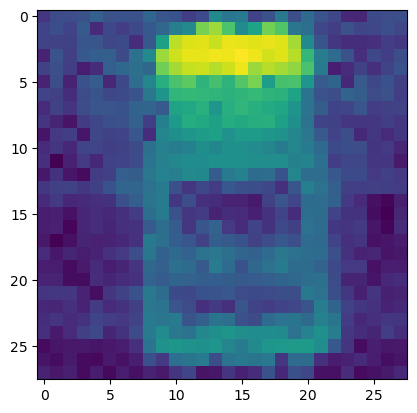

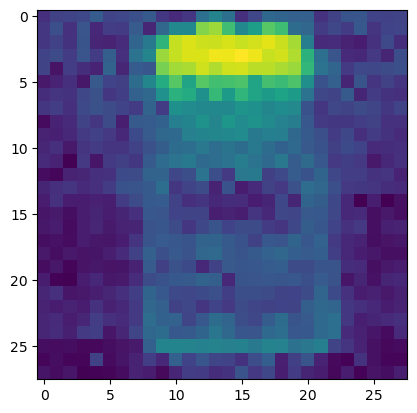

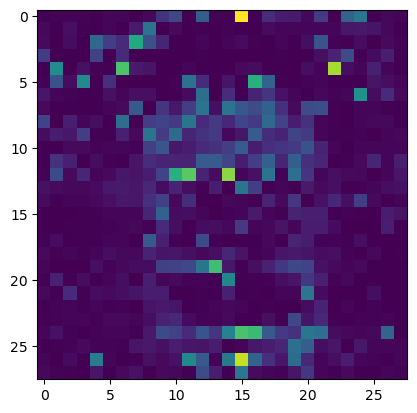

In [453]:
patch_idx = idx * 28 * 28 + 3 * 28 + 15
plt.imshow(embedding[patch_idx].reshape((28, 28)).cpu())
plt.show()
plt.imshow(nearest_embedding[patch_idx].reshape((28, 28)).cpu())
plt.show()
distance_patch = (embedding - nearest_embedding) ** 2
plt.imshow(distance_patch[patch_idx].reshape((28, 28)).cpu())

TypeError: Invalid shape (784,) for image data

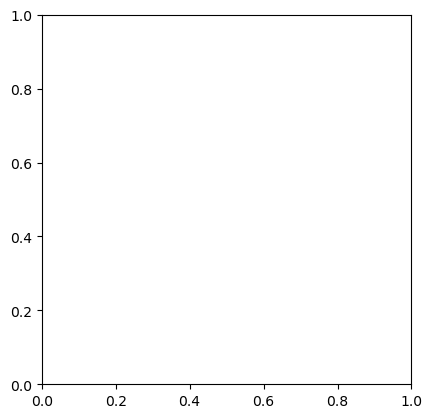

In [40]:
from torchvision.transforms import functional as F

# plt.imshow(corr[0].reshape(28*28, 28*28).unsqueeze(0).cpu()[0])
plt.imshow(corr[0].mean(dim=[1, 2]).cpu())